# Demonstration of Mr.ASH penalized regression

- toc: true
- badges: true
- comments: true
- categories: [trend-filtering, mr-ash, regression-methods]
- slug: mrash-penalized-trend-filtering-demo

### About

In this demo, I illustrate the use of `mr-ash-pen` package for sparse multiple linear regression and trendfiltering. Coefficients are initialized at zero. The residual variance is initialized at 1. The prior initialization is a bit tricky. Currently, I am using the same prior initializations (20 components, as described in Kim et. al.), but different initializations give different results.

In [1]:
#collapse-hide

import numpy as np
from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.models.normal_means_ash import NormalMeansASH

import sys
sys.path.append('/home/saikat/Documents/work/sparse-regression/simulation/eb-linreg-dsc/dsc/functions')
import simulate

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

def center_and_scale(Z):
    dim = Z.ndim
    if dim == 1:
        Znew = Z / np.std(Z)
        Znew = Znew - np.mean(Znew)
    elif dim == 2:
        Znew = Z / np.std(Z, axis = 0)
        Znew = Znew - np.mean(Znew, axis = 0).reshape(1, -1)
    return Znew

def initialize_ash_prior(k, scale = 2):
    w = np.zeros(k)
    w[0] = 1e-8
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

### Linear model with n > p

In [2]:
# collapse-hide

def plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, res):
    bhat = res.coef
    ypred = np.dot(Xtest, bhat)
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(ytest, ypred, s = 2, alpha = 0.5)
    mpl_utils.plot_diag(ax1)
    ax2.scatter(btrue, bhat)
    mpl_utils.plot_diag(ax2)

    ax1.set_xlabel("Y_test")
    ax1.set_ylabel("Y_predicted")
    ax2.set_xlabel("True b")
    ax2.set_ylabel("Predicted b")
    plt.tight_layout()
    plt.show()

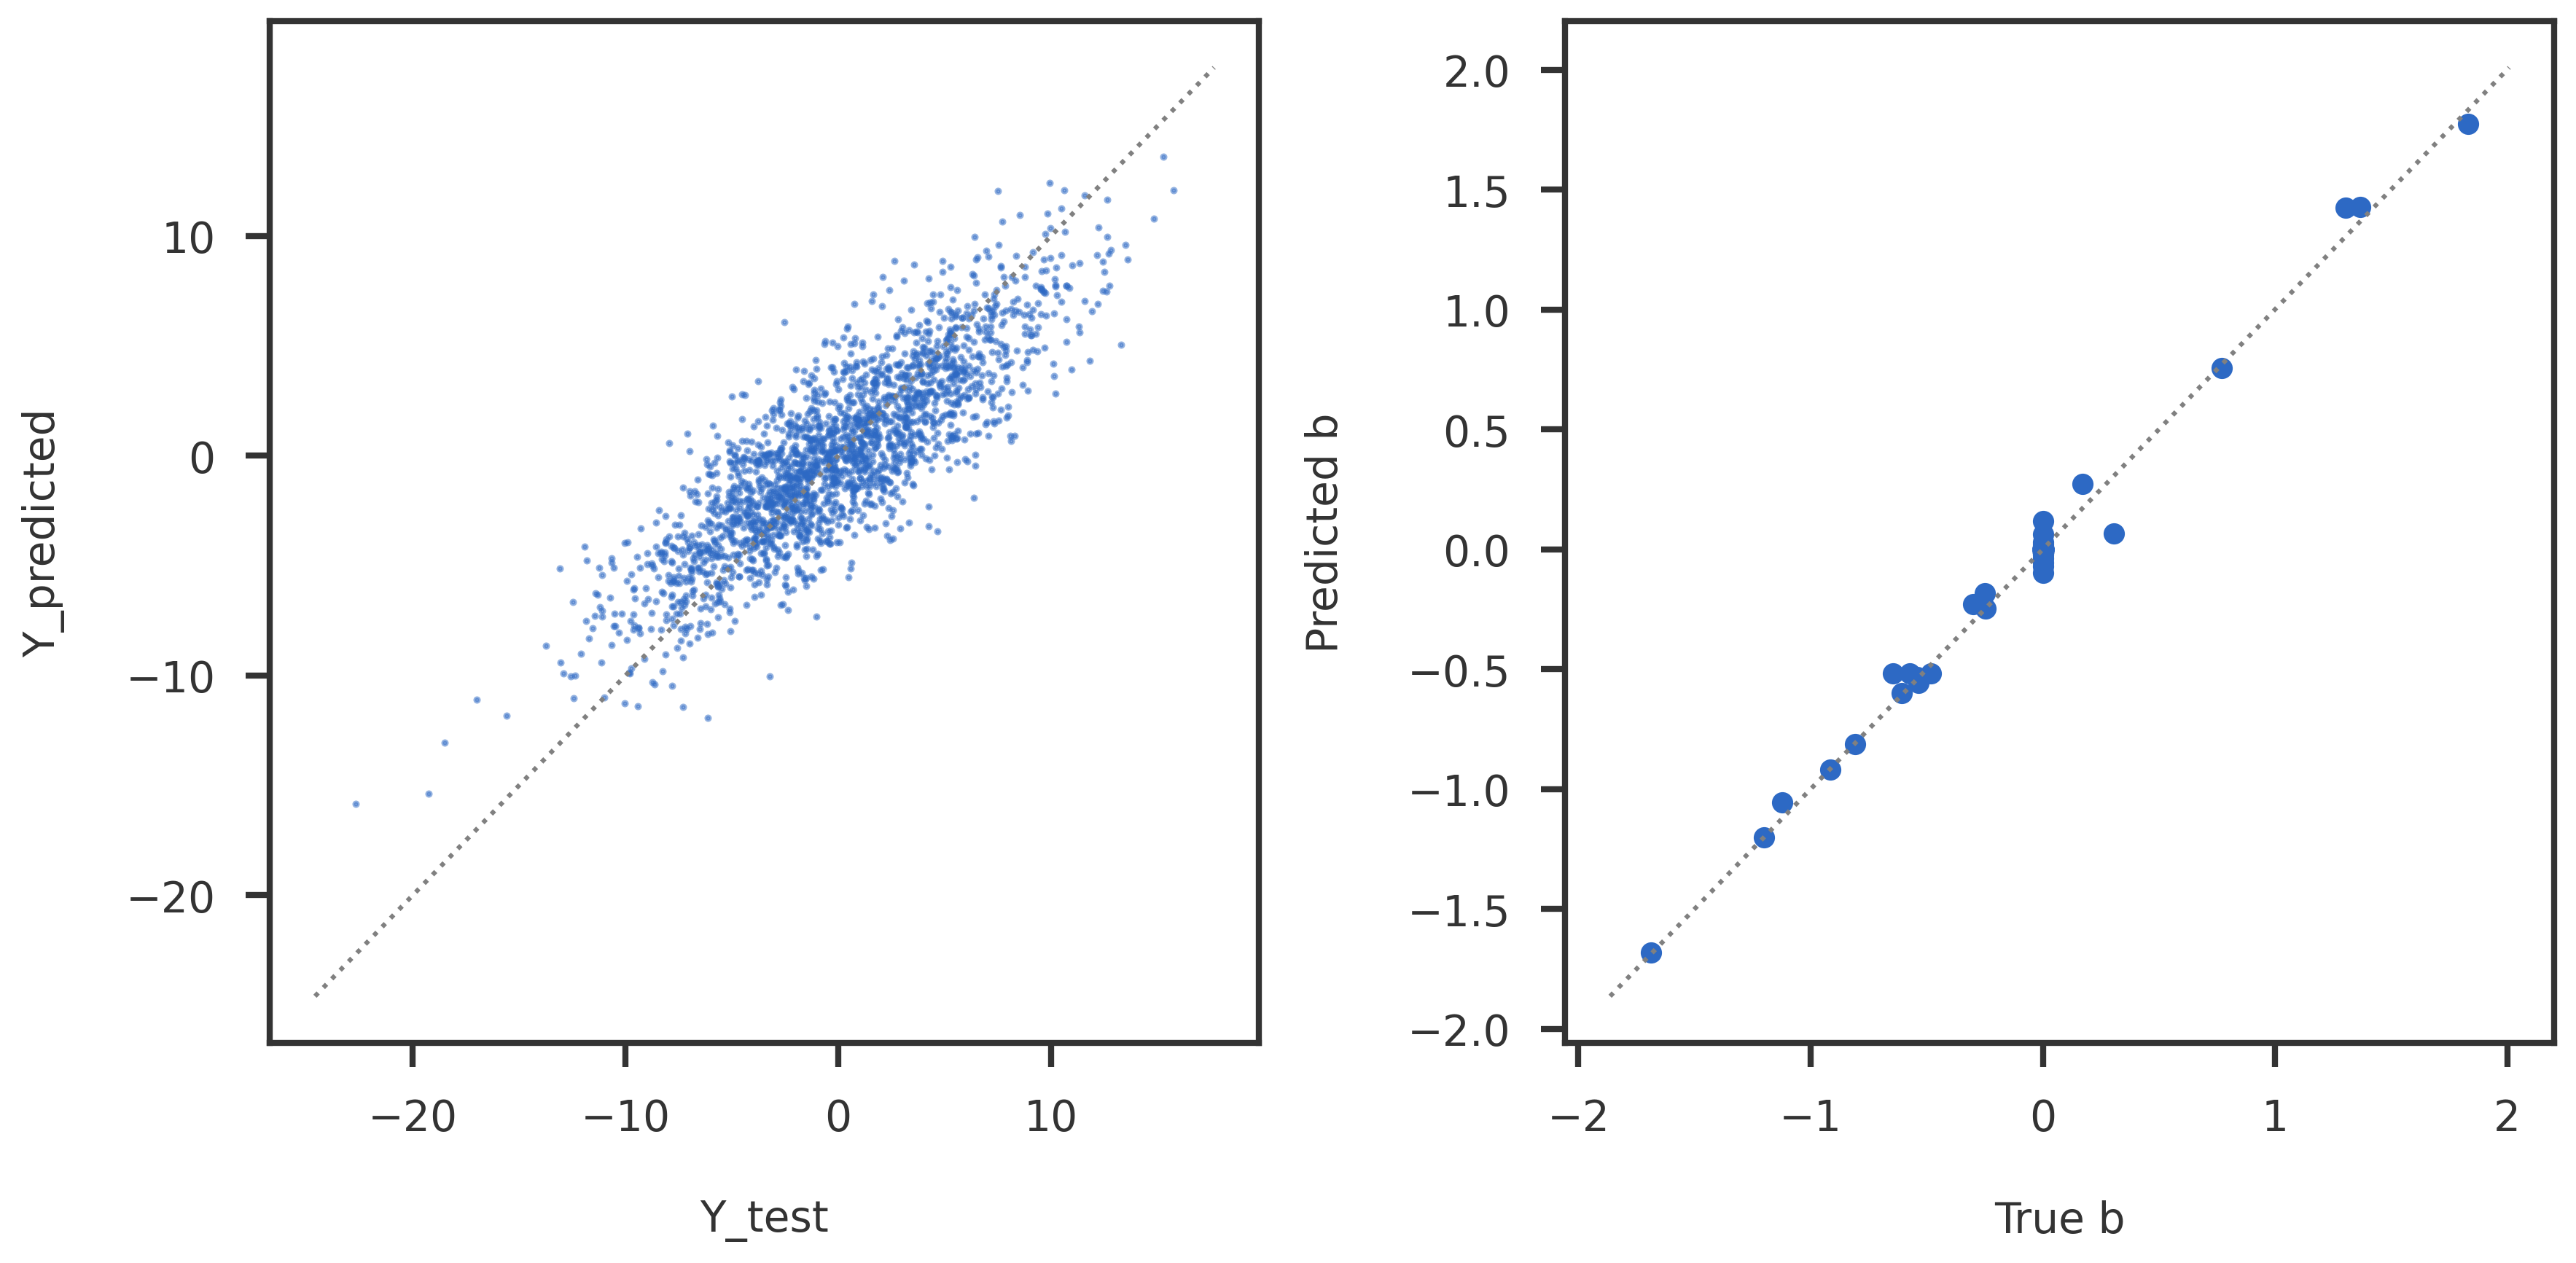

In [3]:
#collapse-show

### Generate data

n = 2000
p = 200
p_causal = 20
pve = 0.7
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = 0.0, seed = 10)
X      = center_and_scale(X)
Xtest  = center_and_scale(Xtest)
wk, sk = initialize_ash_prior(k)

## Optimize
plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = True, is_prior_scaled = True,
                debug = False, display_progress = False)
plr_lbfgs.fit(X, y, sk, binit = None, winit = wk, s2init = 1)

## Plot
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, plr_lbfgs)

### Linear model with n < p

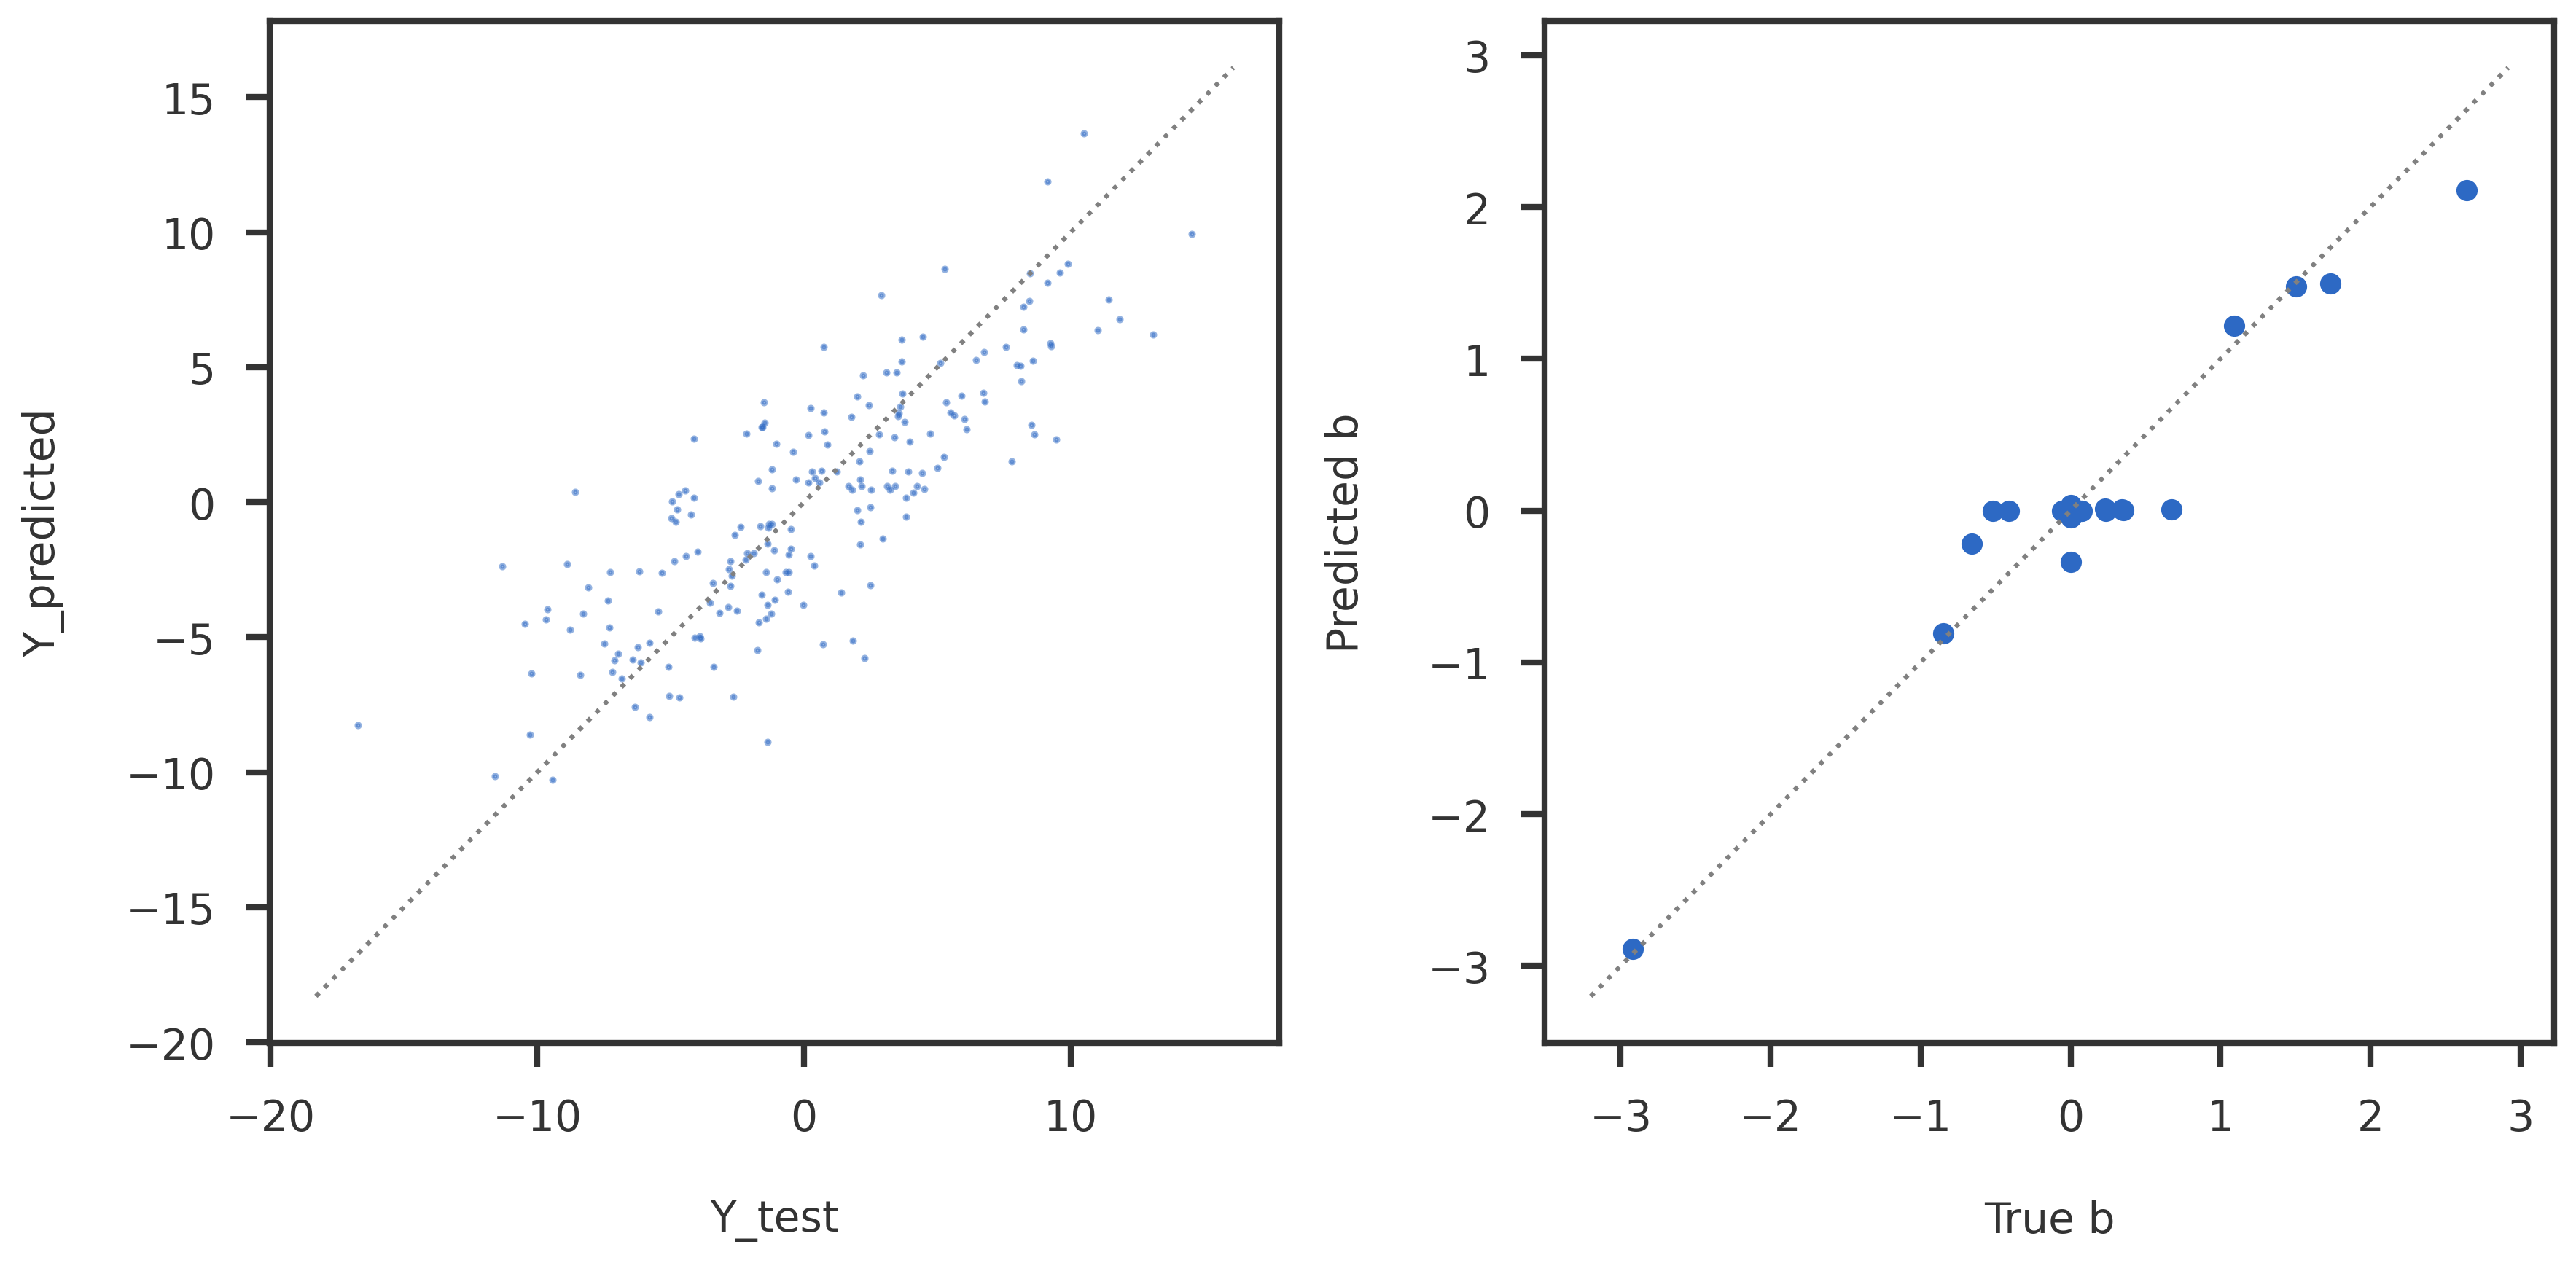

In [4]:
#collapse-show

### Generate data

n = 200
p = 2000
p_causal = 20
pve = 0.7
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = 0.0, seed = 20)
X      = center_and_scale(X)
Xtest  = center_and_scale(Xtest)
wk, sk = initialize_ash_prior(k)

## Optimize
plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = True, is_prior_scaled = True,
                debug = False, display_progress = False)
plr_lbfgs.fit(X, y, sk, binit = None, winit = wk, s2init = 1)

## Plot
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, plr_lbfgs)

### Linear model with n > p and correlated X

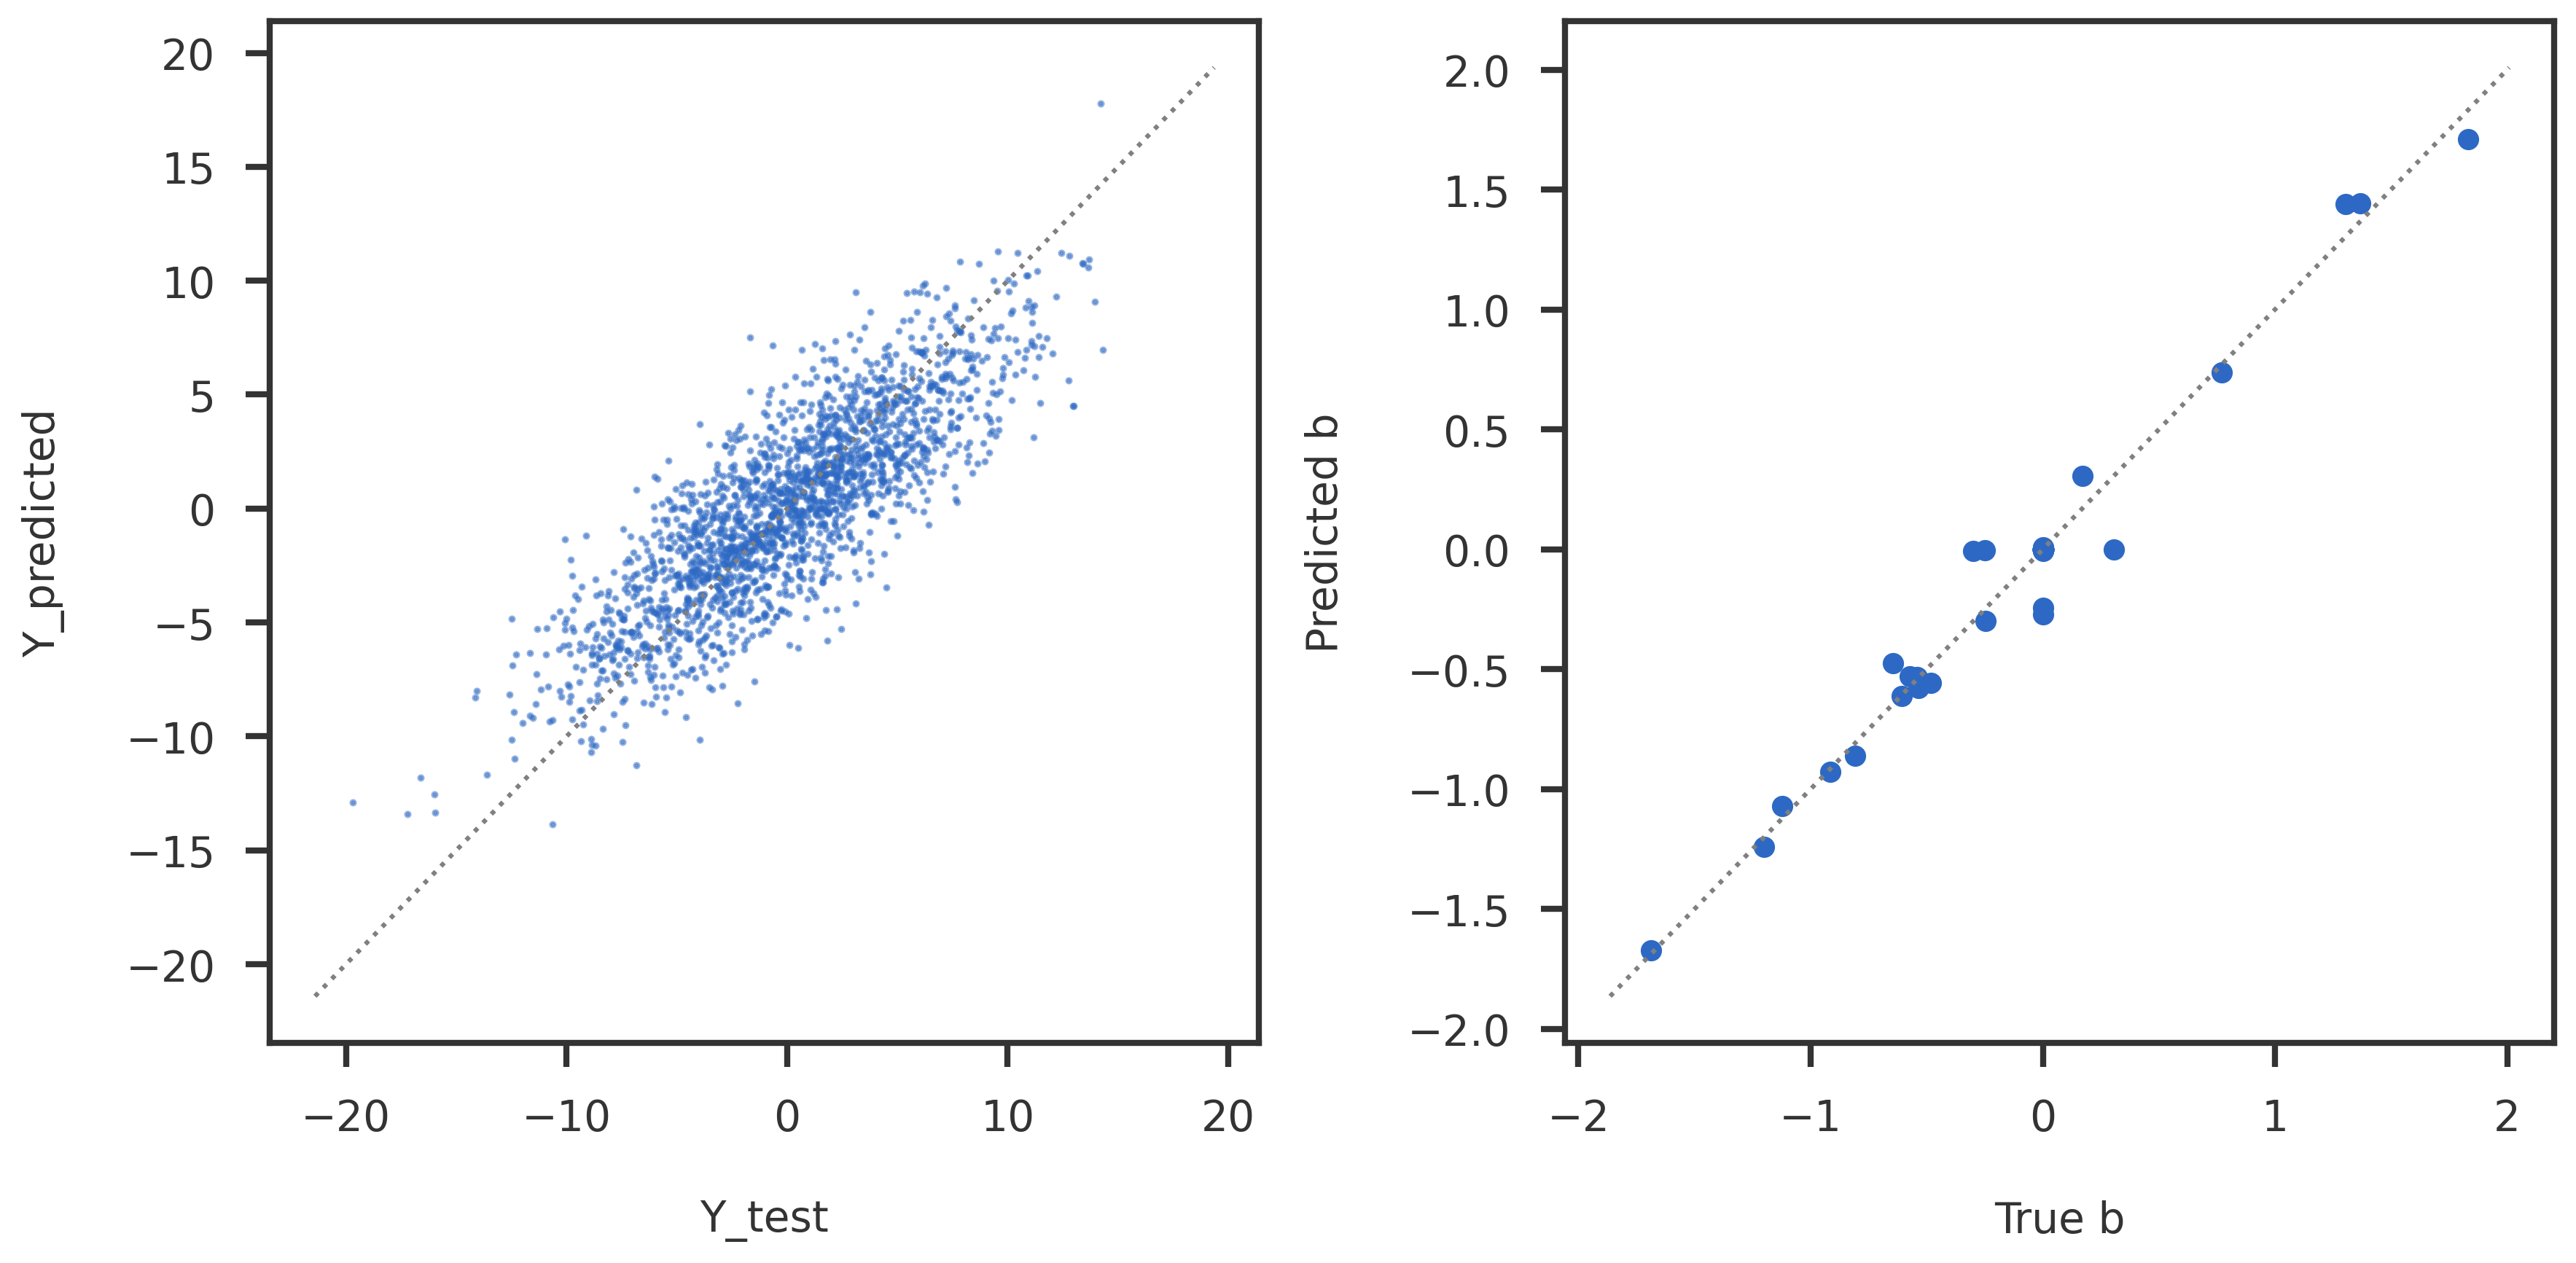

In [5]:
#collapse-show

### Generate data

n = 2000
p = 200
p_causal = 20
pve = 0.7
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = 0.5, seed = 10)
X      = center_and_scale(X)
Xtest  = center_and_scale(Xtest)
wk, sk = initialize_ash_prior(k)

## Optimize
plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = True, is_prior_scaled = True,
                debug = False, display_progress = False)
plr_lbfgs.fit(X, y, sk, binit = None, winit = wk, s2init = 1)

## Plot
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, plr_lbfgs)

### Linear model with n < p and correlated X

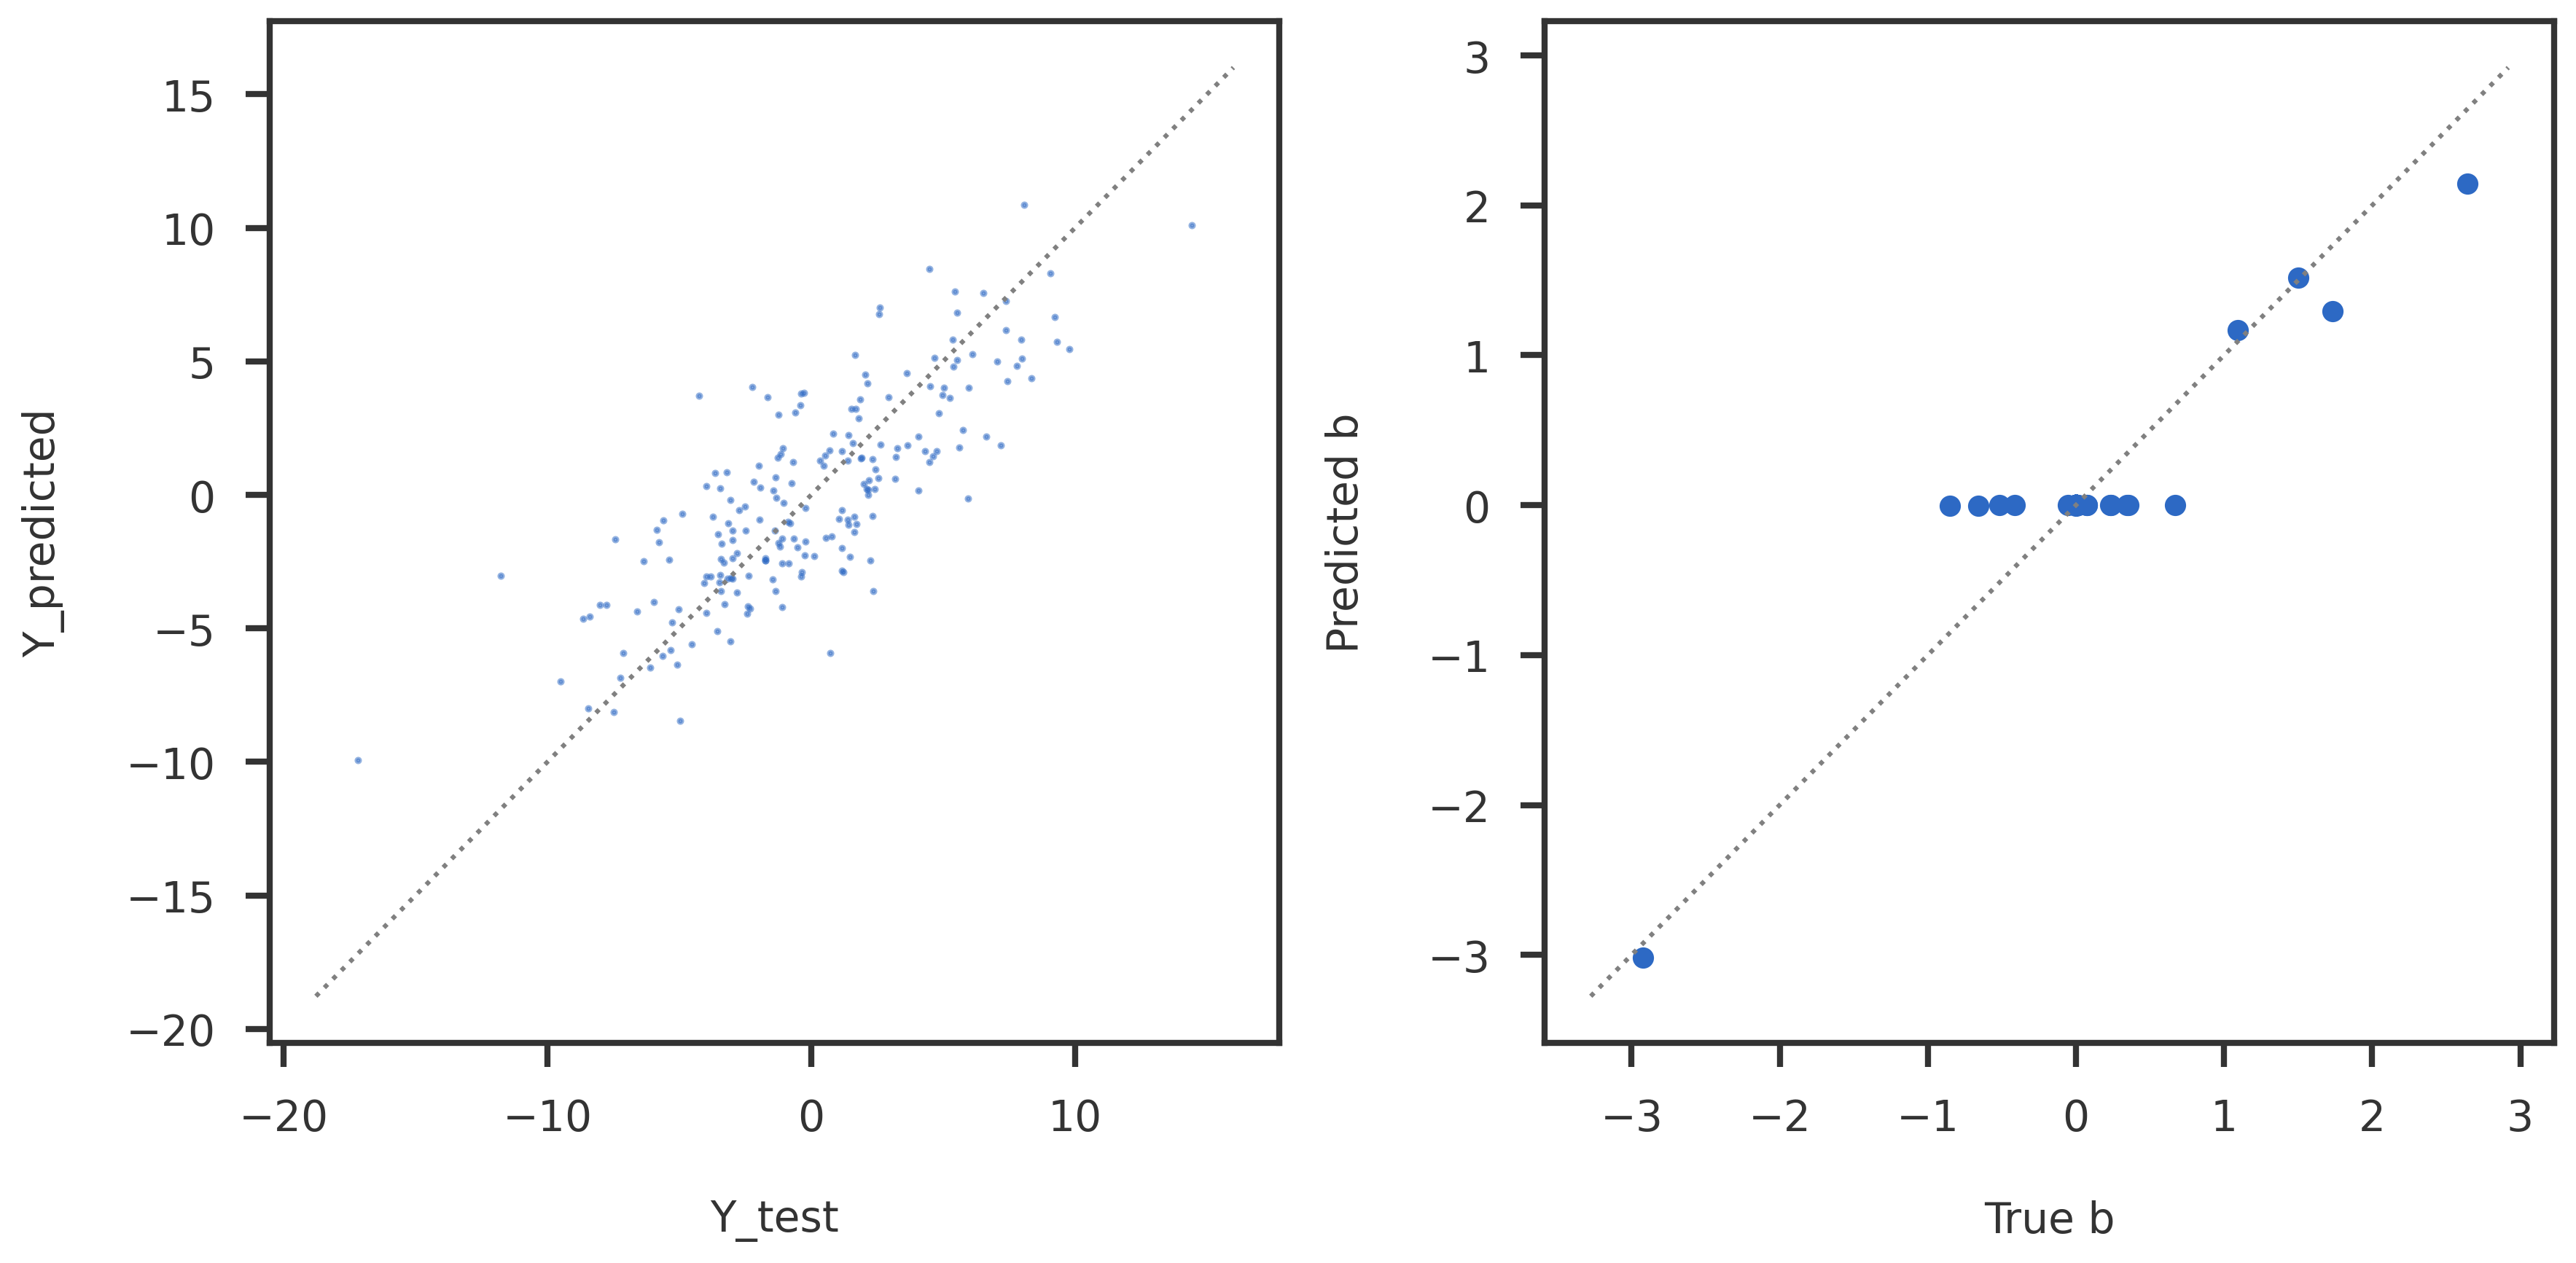

In [6]:
#collapse-show

### Generate data

n = 200
p = 2000
p_causal = 20
pve = 0.7
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = 0.5, seed = 20)
X      = center_and_scale(X)
Xtest  = center_and_scale(Xtest)
wk, sk = initialize_ash_prior(k, scale = 2)

## Optimize
plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = True, is_prior_scaled = True,
                debug = False, display_progress = False)
plr_lbfgs.fit(X, y, sk, binit = None, winit = wk, s2init = 10)

## Plot
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, plr_lbfgs)

### Trendfiltering with basis k = 0

In [7]:
#collapse-hide

def plot_trendfilter_mrashpen(X, y, beta, ytest, res):
    n = y.shape[0]
    p = X.shape[1]

    bhat = res.coef

    ypred = np.dot(X, bhat)
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(np.arange(n), ytest, edgecolor = 'black', facecolor='white', label="ytest")
    ax1.plot(np.arange(n), ypred, label="Mr.Ash.Pen")
    ax1.legend()
    ax1.set_xlabel("Sample index")
    ax1.set_ylabel("y")

    ax2.scatter(np.arange(p), beta, edgecolor = 'black', facecolor = 'white', label = "btrue")
    ax2.scatter(np.arange(p), bhat, s = 10, color = 'firebrick', label = "Mr.Ash.Pen")
    ax2.legend()
    ax2.set_xlabel("Sample index")
    ax2.set_ylabel("b")

    plt.tight_layout()
    plt.show()

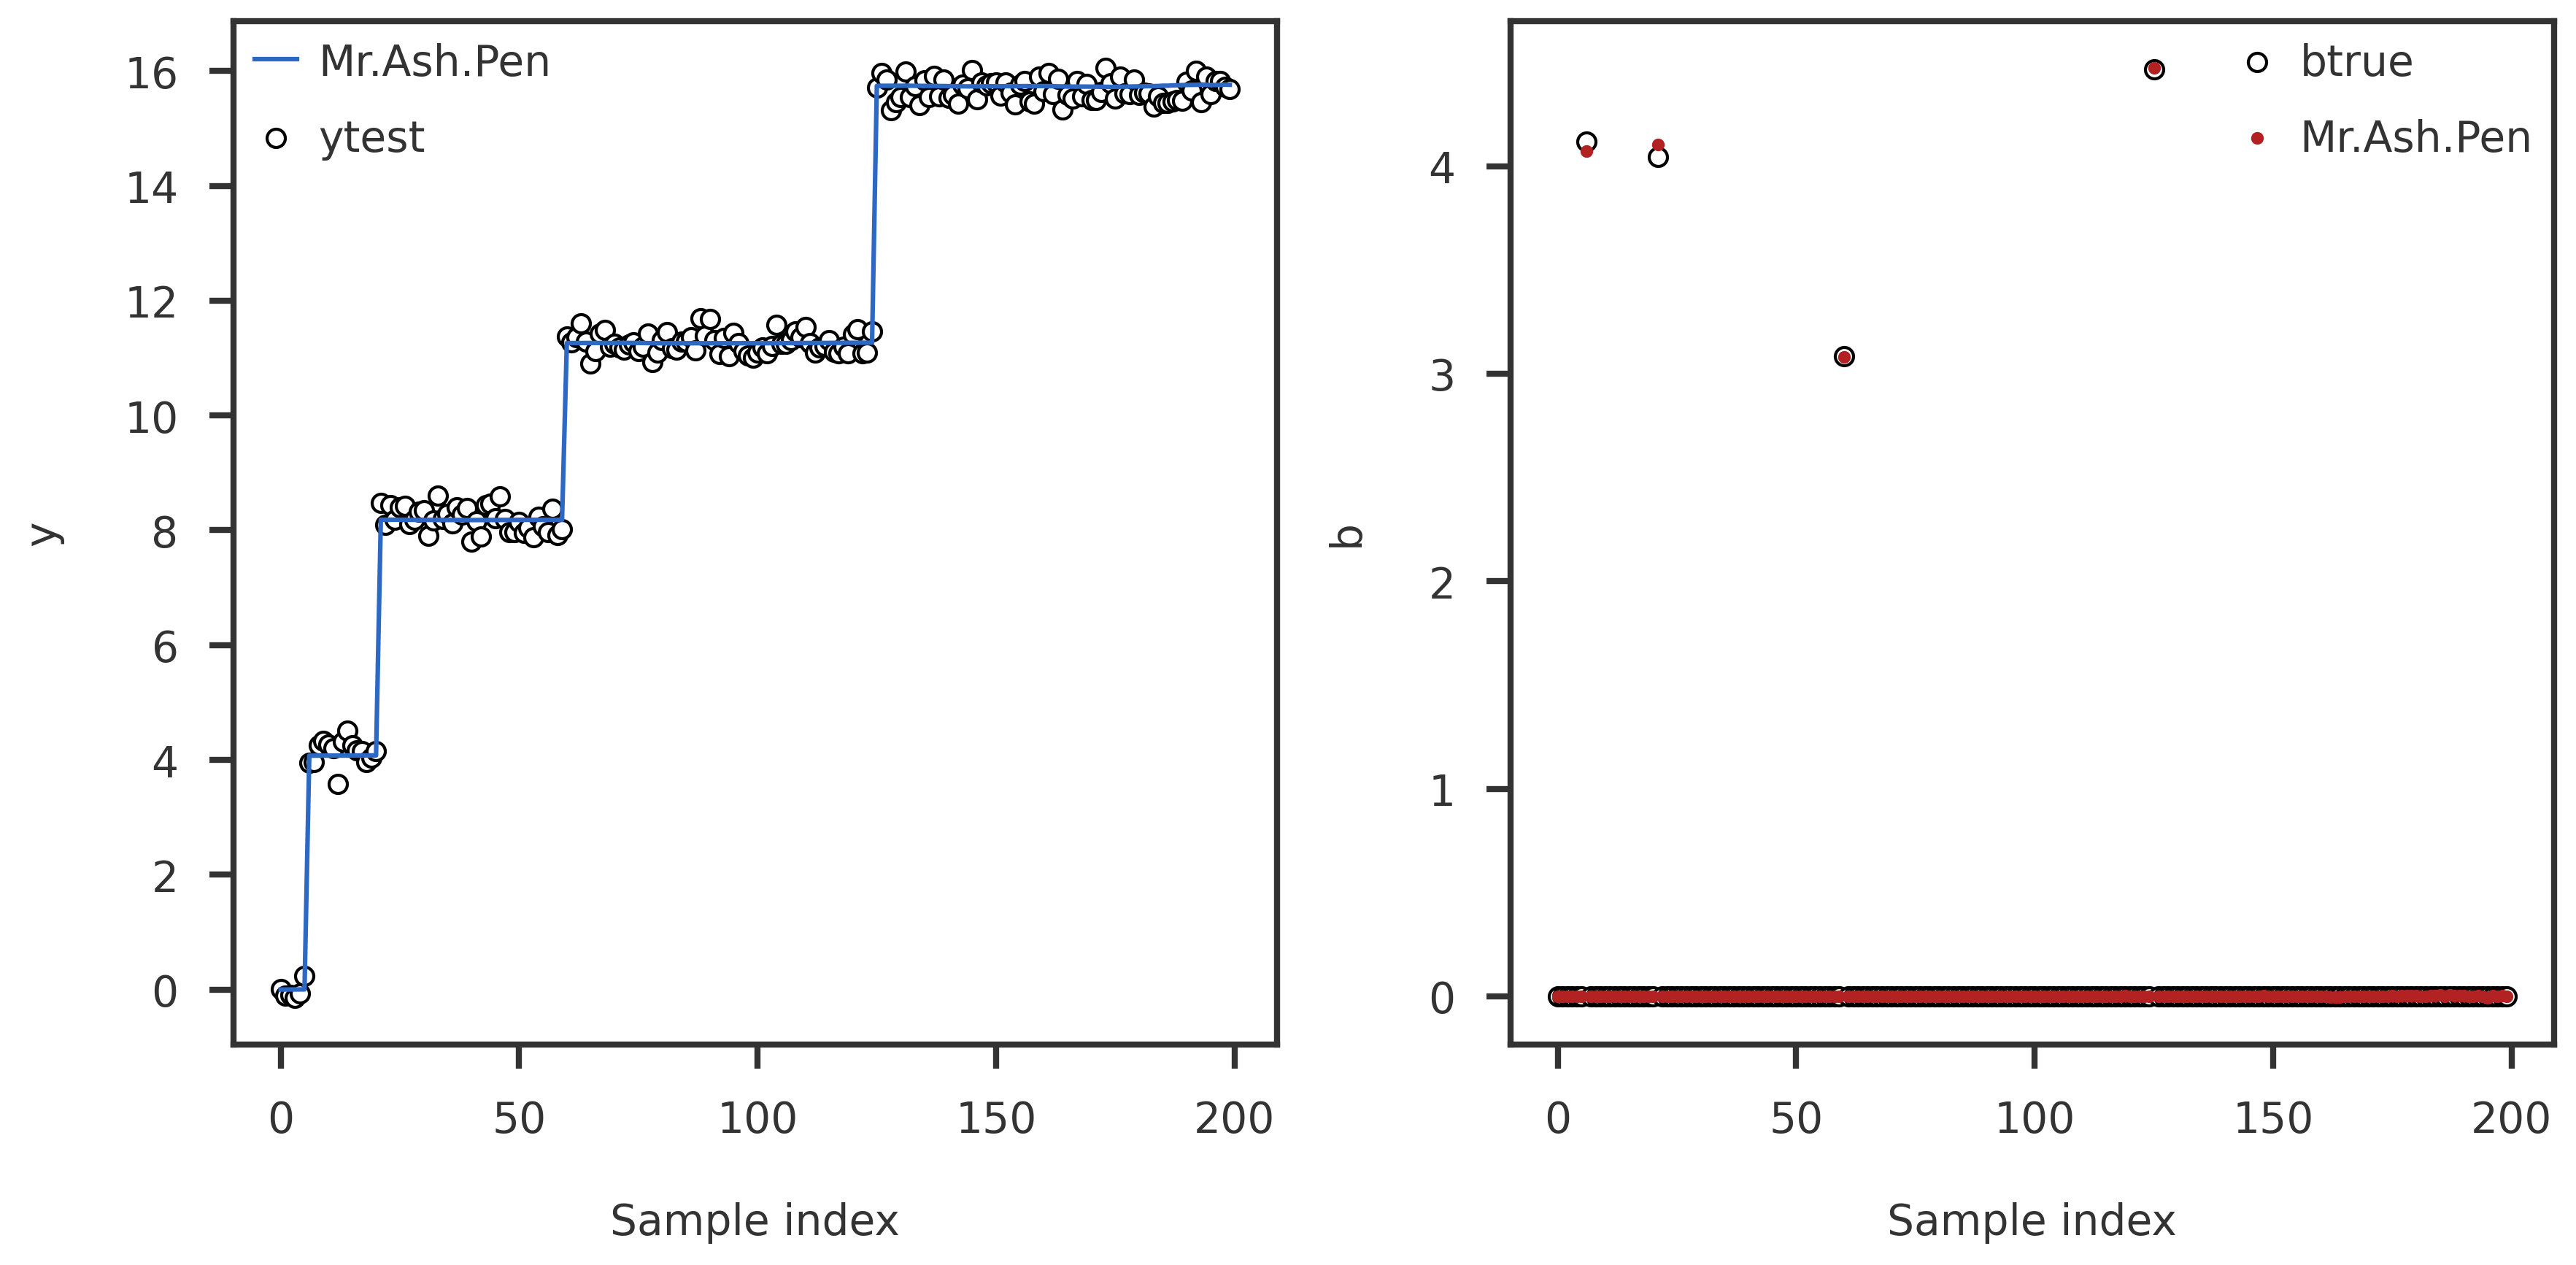

In [8]:
#collapse-show

## Generate data
n = 200
p = 200
p_causal = 4
snr = 20
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.changepoint_predictors (n, p, p_causal, snr, 
                                                                    k = 0, signal = 'gamma', seed = 10)
wk, sk = initialize_ash_prior(k, scale = 10)

## Optimize
plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = True, is_prior_scaled = True,
                debug = False, display_progress = False)
plr_lbfgs.fit(X, y, sk, binit = None, winit = wk, s2init = 1)

## Plot
plot_trendfilter_mrashpen(X, y, btrue, ytest, plr_lbfgs)

### Trendfiltering with less sparsity (p_causal = 20)

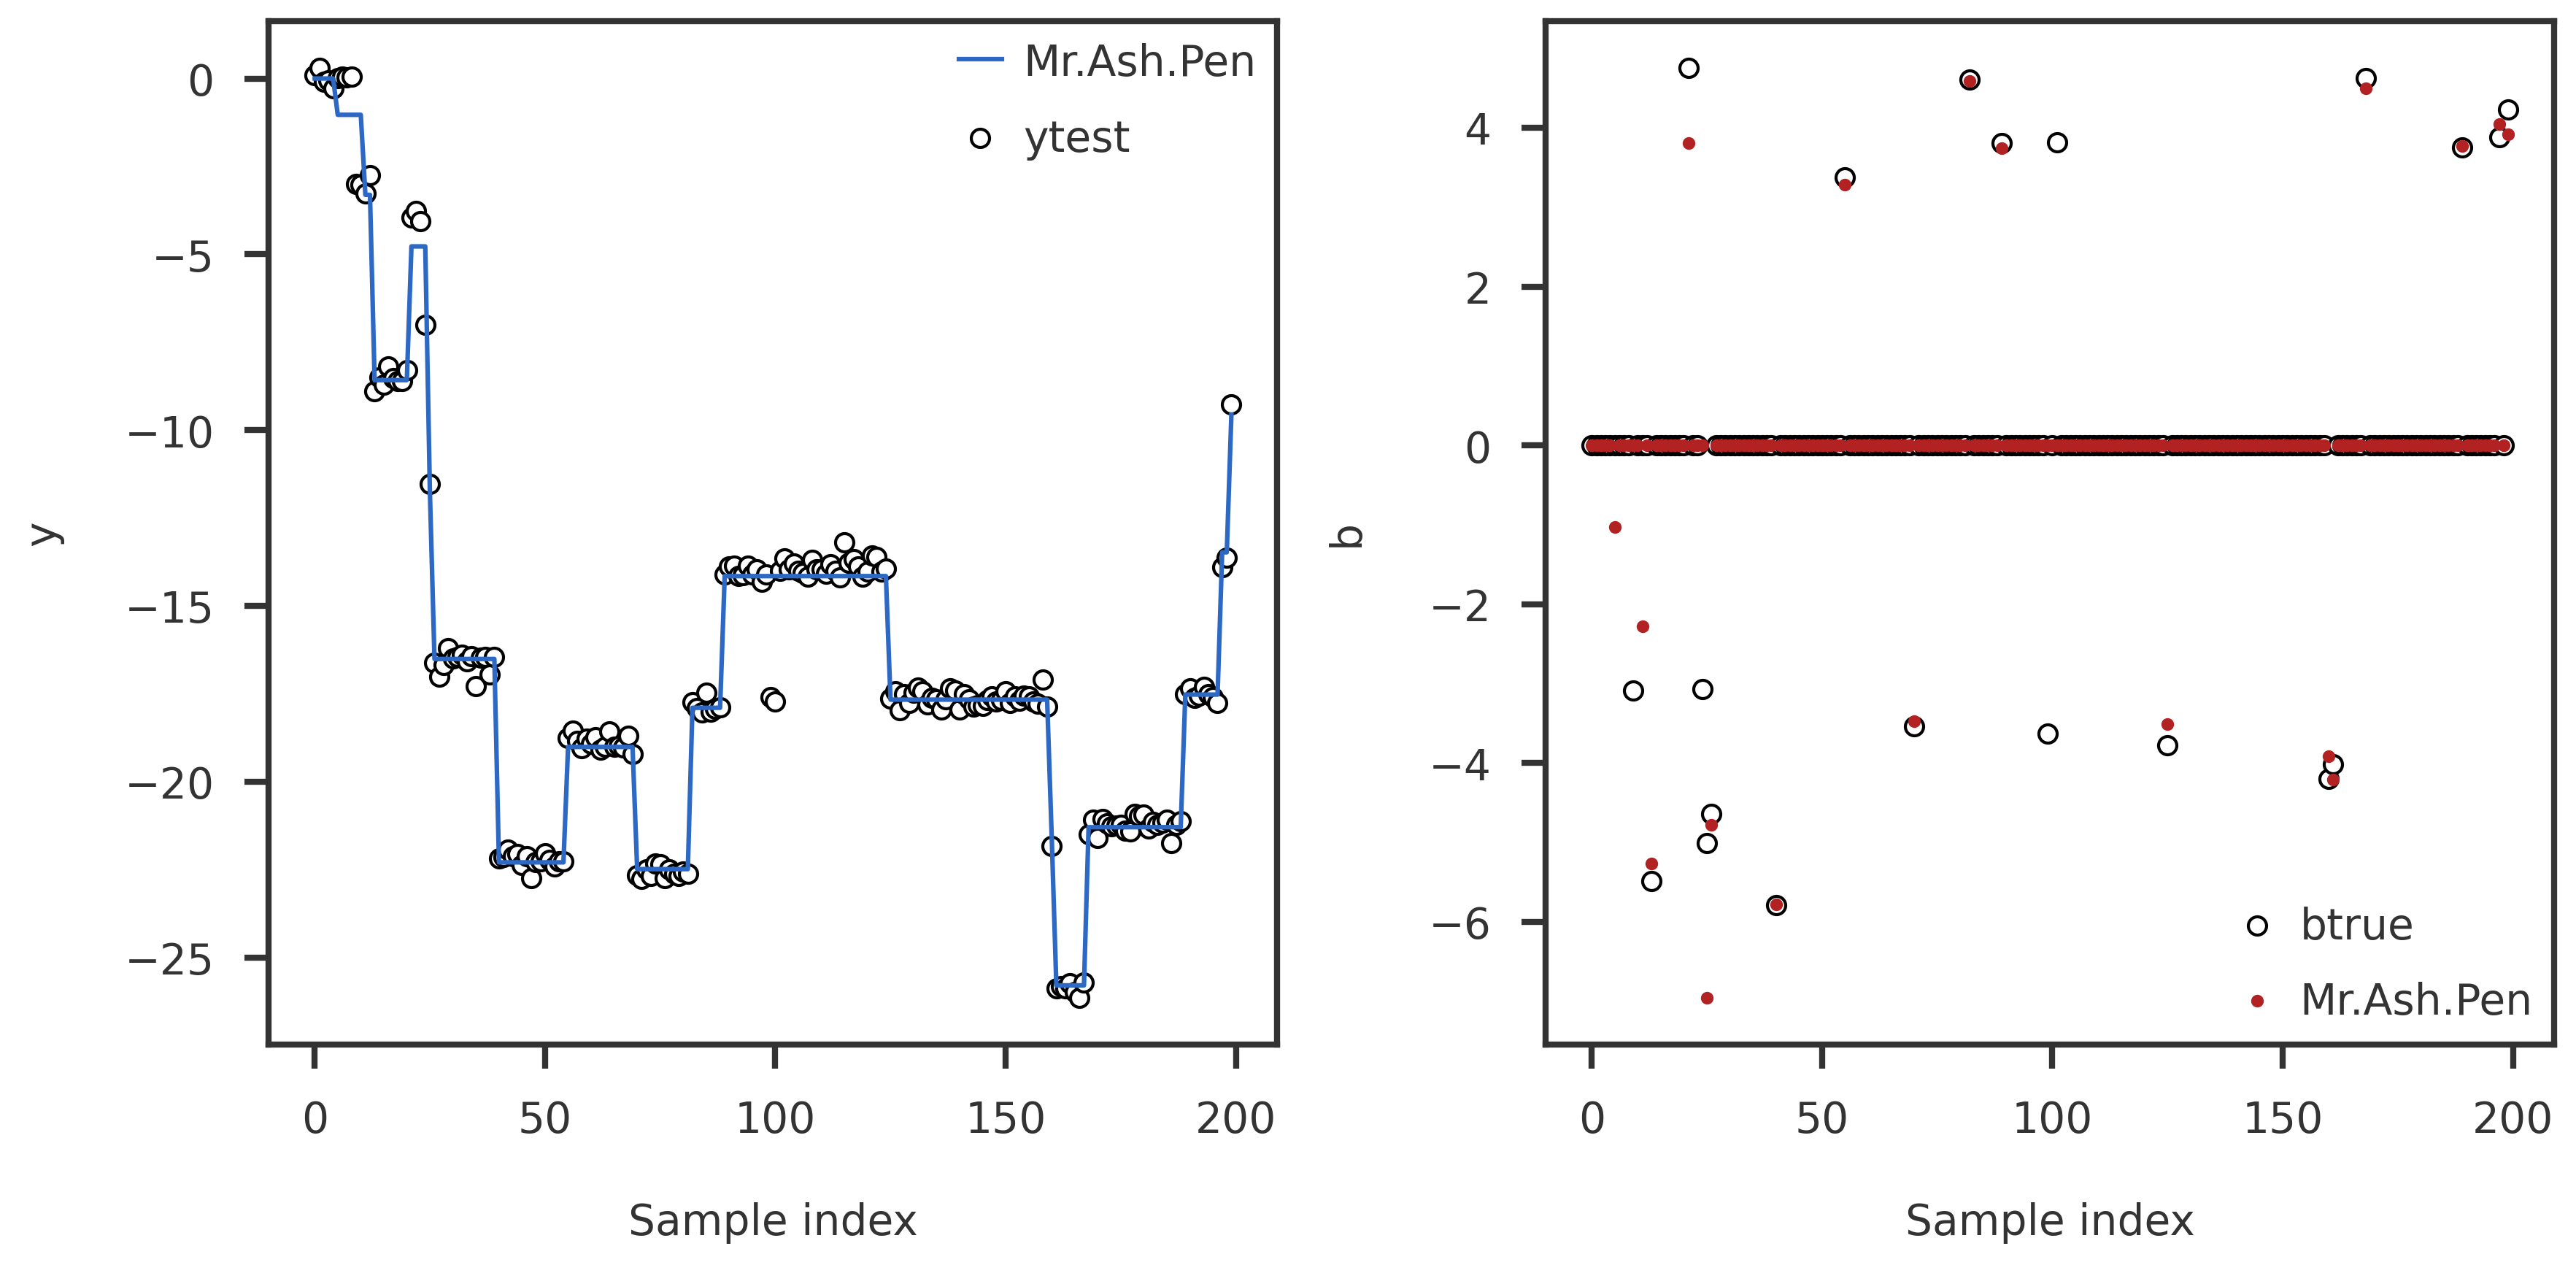

In [9]:
#collapse-show

## Generate data
n = 200
p = 200
p_causal = 20
snr = 20
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.changepoint_predictors (n, p, p_causal, snr, 
                                                                    k = 0, signal = 'gamma', seed = 50)
wk, sk = initialize_ash_prior(k, scale = 10)

## Optimize
plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = True, is_prior_scaled = True,
                debug = False, display_progress = False)
plr_lbfgs.fit(X, y, sk, binit = None, winit = wk, s2init = 1)

## Plot
plot_trendfilter_mrashpen(X, y, btrue, ytest, plr_lbfgs)

### Trendfiltering with basis k = 1

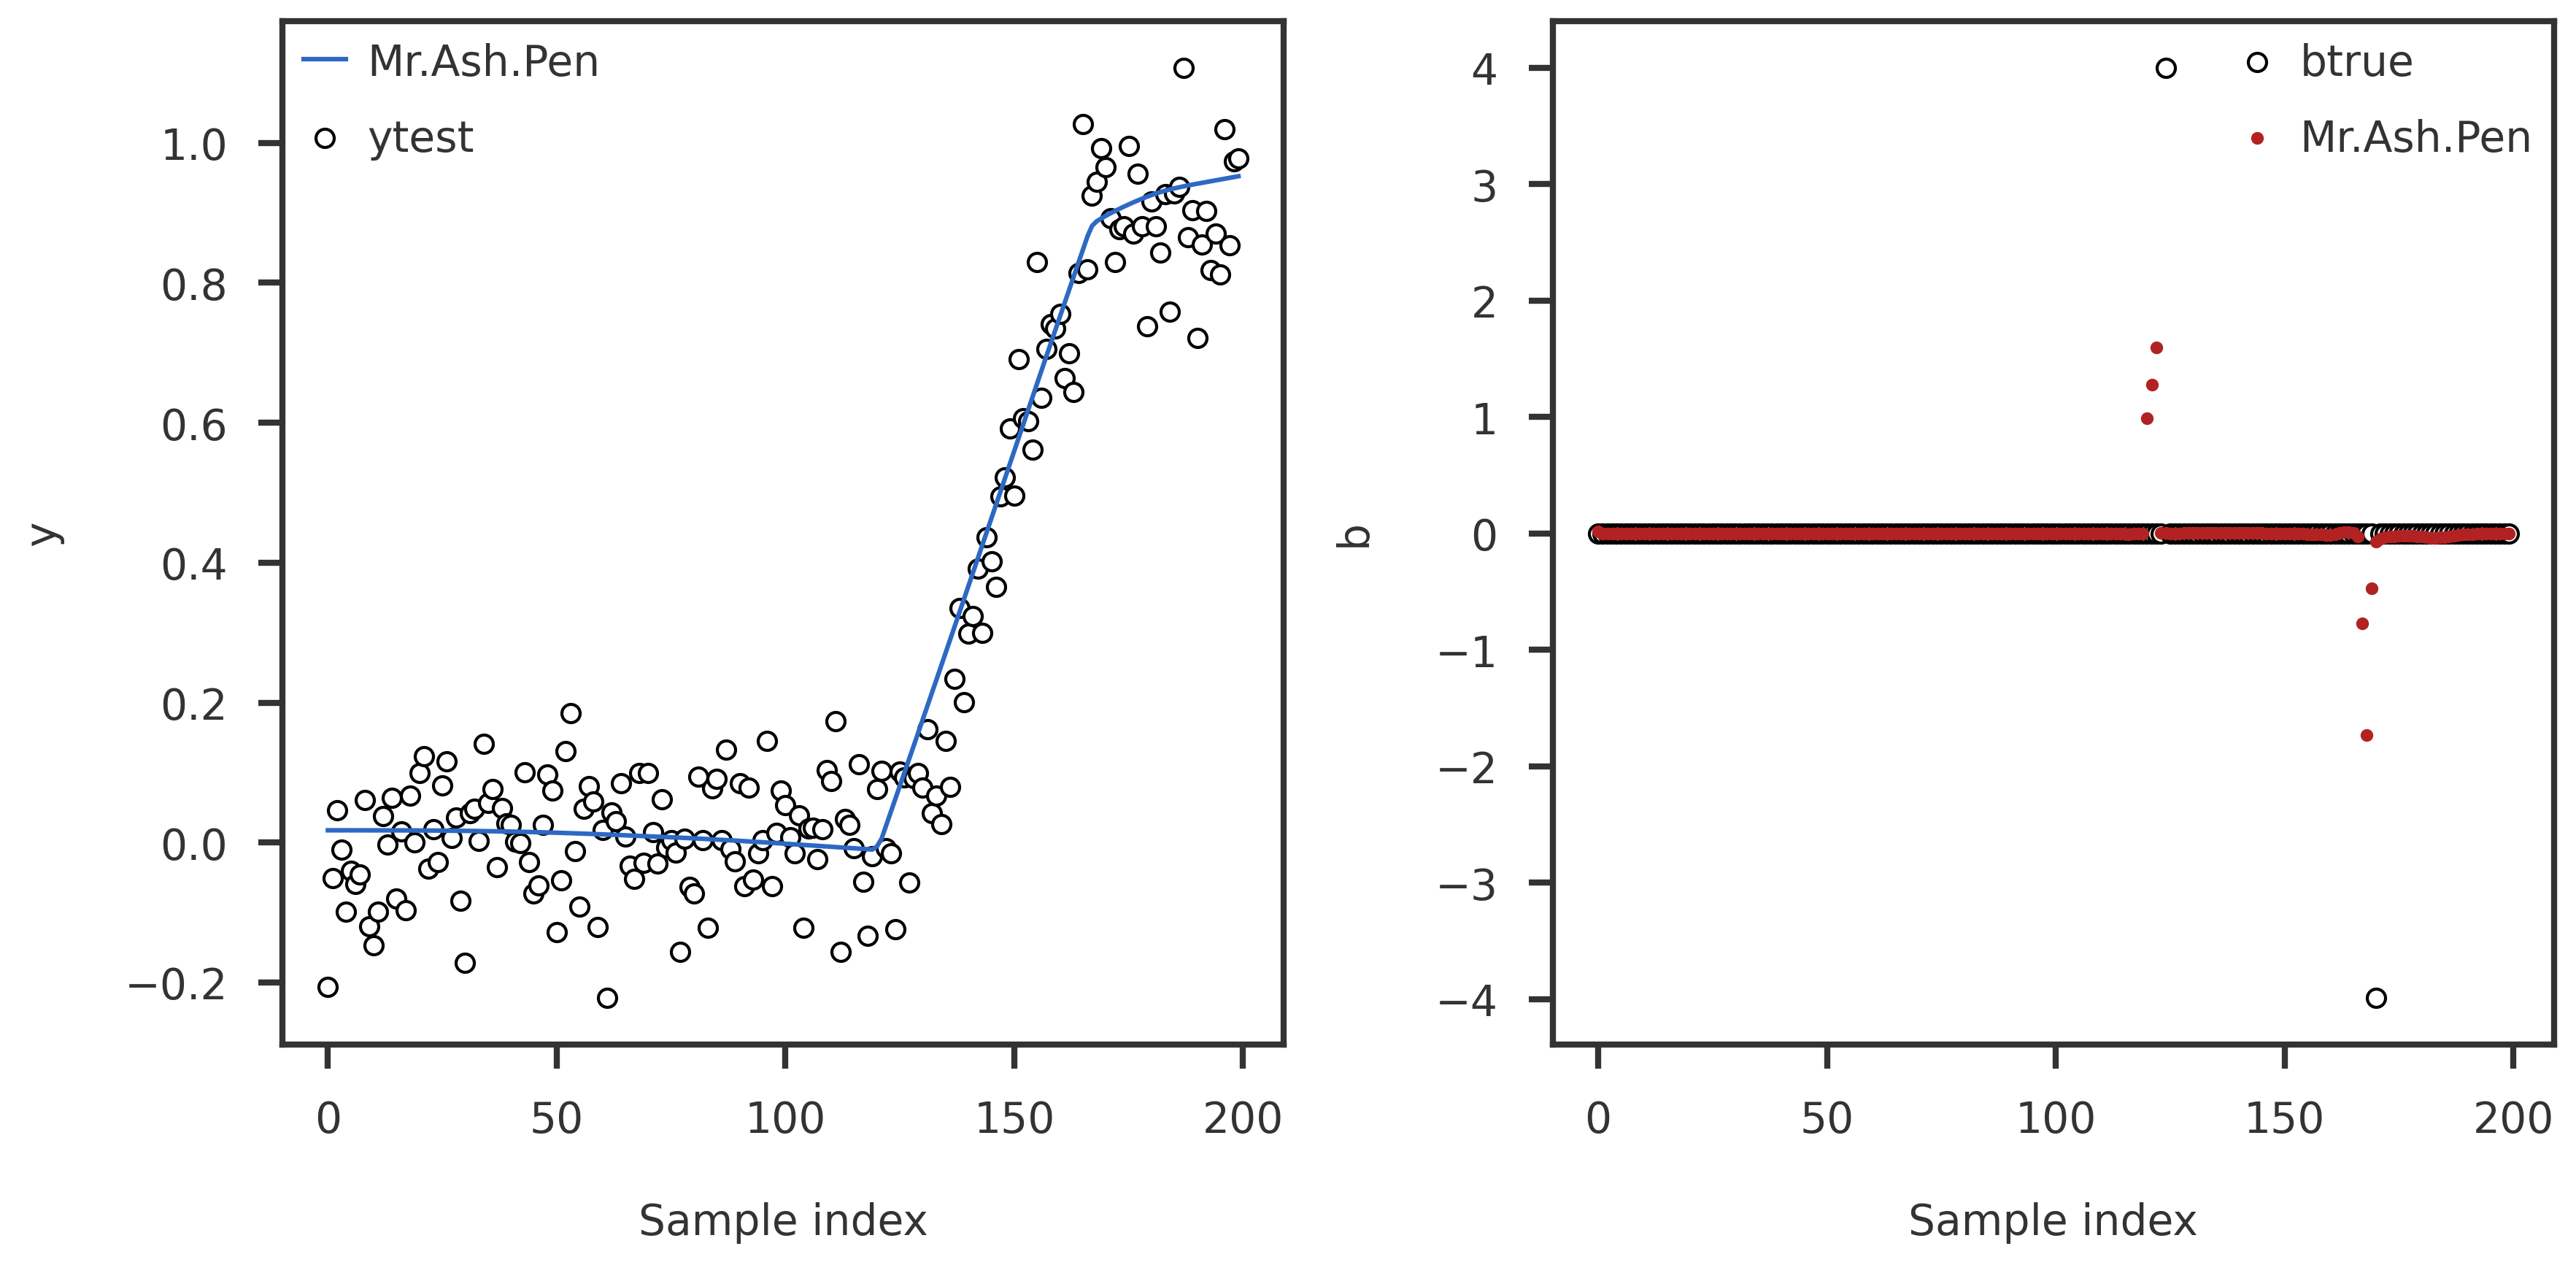

In [10]:
#collapse-show

## Generate data
n = 200
p = 200
p_causal = 2
snr = 50
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.changepoint_predictors (n, p, p_causal, snr, 
                                                                    k = 1, signal = 'gamma', seed = 200)
wk, sk = initialize_ash_prior(k, scale = 20)

## Optimize
plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = True, is_prior_scaled = True, 
                debug = False, display_progress = False)
plr_lbfgs.fit(X, y, sk, binit = None, winit = wk, s2init = 0.01)

## Plot
plot_trendfilter_mrashpen(X, y, btrue, ytest, plr_lbfgs)

In [11]:
import sys
print(sys.version)

3.9.6 (default, Aug 18 2021, 19:38:01) 
[GCC 7.5.0]
